This Jupyter notebook, which is based on Python 3, is designed to calculate the abundances of N elements in the neutron star merger mixture. The notebook will contain several functions to easily calculate values such as temperature, abundances, and ionization potentials.

In this notebook, I have a function for the potentials, initialization of values, calculation of abundances, and plotting

In [1]:
#Importing Libraries
import saha_mult #Class used to calculate abundances 
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
from time import process_time #Useful for finding calculation times
import pickle #for saving data in lists to txt files.


import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook

<module 'saha_mult' from 'C:\\Users\\prana\\Documents\\Research\\R-process_Mergers\\Abundance_Calculations\\Fixing_Cutoff\\saha_mult.py'>

In [2]:
#Read in data for ionization potentials and skynet stuff
#Note that the NIST data table includes many elements that just skip ionization potentials, so I set a cutoff at Lr.
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [3]:
#This function here will return all the ionization potentials of the desired elements. Enter the starting element and
#ending element Z number. This will return an array of arrays. Note the starting position of the array!

#The way I did this was similar to the Multiple Elements Scenario code, but I added an extra array called 
#returned_potentials, which is designed to return an array of all the desired potentials we wanted
ion_energies1d =  nist[' Ionization  Energy (eV)']

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()

        for j in range(i):

            if isinstance(ion_energies1d[counter],str):

                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 

                    for k in ion_energies1d[counter]:

                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k

                    specific_list.append(np.abs(float(str_num)))
                    counter+=1


            else:
                specific_list.append(np.array((np.abs(ion_energies1d[counter]))))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
        
    for i in range(len(elements)):
        returned_potentials.append(np.array((ion_energies[elements[i]])))        
        
    return np.array(returned_potentials)

In [4]:
#This cell is simply for temperature, and since it does not change no matter the elements used, I do not use a function
#At some point, I will have to find a way to find the places to calculate the indices to use to find slope for other hdf5s
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []

linear = np.polyfit(np.log10(np.array(time[900:1700])),np.log10(np.array(temperature[900:1700])),1)
m = linear[0]

for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])

In [5]:
#initialization of ionization potentials and full abundances from Skynet
#used in the abundance calculation function
abundance = hf["Y"]
charge = hf["Z"]
density = hf["Density"]
Ye_tot = hf['Ye']
kbEvpGK = 8.617e-5*1e9

def initialization(elements):

    full_abundance = []
    ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance),np.array(ion_potential)

In [6]:
#Abundance function
def abundance_calculation(elements):
    x,y = initialization(elements)
    return (saha_mult.GetAbundances(x,np.array(full_temp),np.array(density),y))

In [7]:
#Function to plot the abundances, the sum of all ionization states, and the graphical check
#At some point, I might add functionality to choosing which things to graph

#1 hr = 3600 sec
#2 Weeks = 1.21e+6 seconds

def plotter(abun):
    
    time_start = process_time()
    #colors = ['r','b'] #Just a color scheme to indicate varying elements instead of having too many colors.
    x = np.zeros((len(abun[0]),len(abun[-1][0]))) #Initializing the array useful in tracking ionization state abundances
    checksum = []#Another way to calculating the total sum across time. 
    index_total = [] #Calculating total sum across time 
       
    #Plotting abundances vs Temp
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot,)
            plt.xlabel("Temperature(eV)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    
    plt.show()
    
    
    #Plotting abundances vs Time
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(time,(Y[:,i])/Ytot,)
            plt.xlabel("Time(sec)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Time")
    
    plt.show()
    
    
    #PLot of all Rel. Isoelectronic State Abundances over Temperature
    #So this sums up the abundances of everything with the same number of electrons.
    for Y in abun:
        x[0:len(Y),0:len(Y[0])]+=Y[:,-1::-1]
    
    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(kbEvpGK*np.array(full_temp),x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Temperature")
        plt.xlim([0.1,10])
        plt.ylim([1.e-3, 1])
        
        
    plt.show()
    
    #Time vs Total Rel.Isoelectronic State Abundances

    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(time,x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Time")
        plt.xlim([3600,1.21e+6]) #Specific range for 1 hr to 2 weeks of time in sec
        plt.ylim([1.e-3, 1])
        
    plt.show()
    
    
    #Plotting the Graphical Check
    for i in range(len(abun[0])):
        summation = 0
        temp_sum = 0
        for Y in abun:
            summation+=np.sum(Y[i])
            temp_sum+=np.sum(Y,1)
        checksum.append(summation)
        index_total.append(temp_sum)
    
    plt.semilogx(kbEvpGK*np.array(full_temp),np.array(checksum)/np.array(index_total))
    plt.xlabel("Energy(eV)")
    plt.ylabel("Ratio of Sum of Rel. Abundances per Timestep over Total")
    plt.title("Graphical Check of Rel. Abundances")
    plt.show()
    
    
    #Quick calculation of how long it takes
    time_elapsed = (process_time() - time_start)
    print("This calculation took",time_elapsed,' sec to graph')

In [8]:
#def plotterfunction2 for graphing the majority of the graphs

C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:133: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:134: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:145: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


This calculation took 2.34375  sec


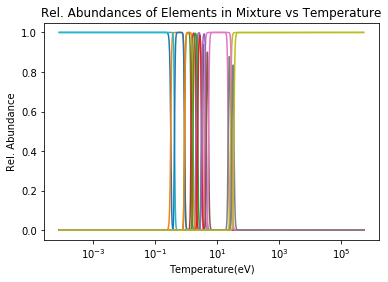

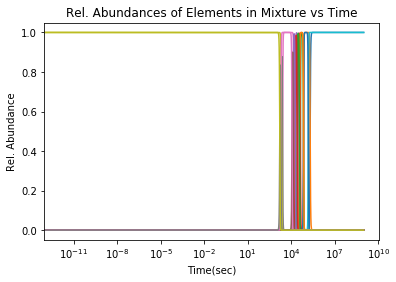

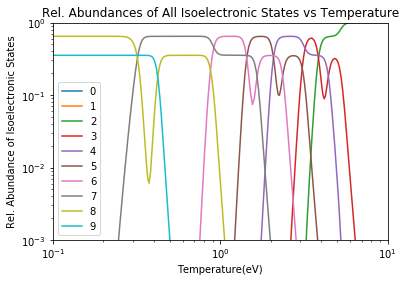

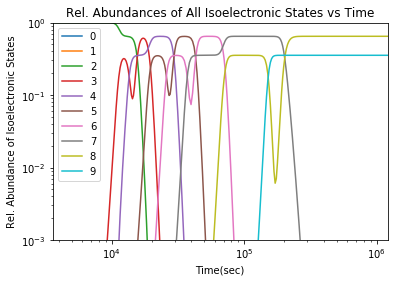

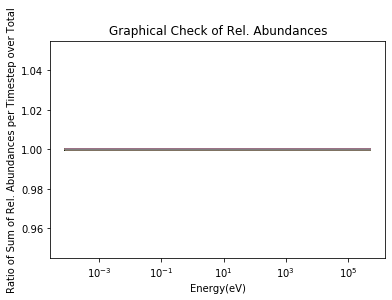

This calculation took 4.609375  sec to graph


In [9]:
#Call to function to generate data. Also, calculate time it takes.

time_start = process_time()
YI,bad,Ye_free,Ye_bound,Ye_f_Mid,abundance_using_Ye_tot = abundance_calculation([8,9])
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')
plotter(YI)

In [10]:
#Saving Data as .txt files
time_start = process_time()
YI,bad,Ye_free,Ye_bound,Ye_f_Mid,abundance_using_Ye_tot = abundance_calculation(np.arange(1,104,1))
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')

with open("bad_testing.txt", 'wb') as fp:
        pickle.dump(YI, fp)
        
with open("bad_array.txt", 'wb') as fp:
        pickle.dump(bad, fp)
        
with open("Ye_free.txt", 'wb') as fp:
        pickle.dump(Ye_free, fp)
        
with open("Ye_bound.txt", 'wb') as fp:
        pickle.dump(Ye_bound, fp)

with open("Ye_f_Mid.txt","wb") as fp:
    pickle.dump(Ye_f_Mid,fp)

This calculation took 190.109375  sec


In [8]:
#Loading in the files
with open("bad_testing.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)
        
with open("bad_array.txt", "rb") as fp:   # Unpickling
      bad = pickle.load(fp)

with open("Ye_free.txt", "rb") as fp:   # Unpickling
      Ye_free = pickle.load(fp)

with open("Ye_bound.txt", "rb") as fp:   # Unpickling
      Ye_bound = pickle.load(fp)
        
with open("Ye_f_Mid.txt","rb") as fp:
      Ye_f_Mid = pickle.load(fp)  

In [9]:
elemental,potentials = initialization(np.arange(1,104,1))

In [11]:
pd.DataFrame(YI[61])

0              1              2              3   \
0      7.763804e-85   1.613125e-84   3.351635e-84   6.963620e-84   
1      7.763804e-85   1.613125e-84   3.351635e-84   6.963620e-84   
2      7.763805e-85   1.613125e-84   3.351635e-84   6.963620e-84   
3      7.763805e-85   1.613125e-84   3.351636e-84   6.963621e-84   
4      7.763806e-85   1.613125e-84   3.351636e-84   6.963622e-84   
5      7.763809e-85   1.613126e-84   3.351637e-84   6.963624e-84   
6      7.763814e-85   1.613127e-84   3.351640e-84   6.963629e-84   
7      7.763824e-85   1.613129e-84   3.351644e-84   6.963638e-84   
8      7.763845e-85   1.613133e-84   3.351653e-84   6.963657e-84   
9      7.763885e-85   1.613142e-84   3.351670e-84   6.963693e-84   
10     7.763967e-85   1.613159e-84   3.351706e-84   6.963767e-84   
11     7.764129e-85   1.613192e-84   3.351776e-84   6.963913e-84   
12     7.764454e-85   1.613260e-84   3.351917e-84   6.964206e-84   
13     7.765101e-85   1.613395e-84   3.352197e-84   6.964788e-84   
14     7.766384e-85   1.613661e-84   3.352752e-84   6.965944e-84   
15     7.769872e-85   1.614387e-84   3.354261e-84   6.969083e-84   
16     8.491343e-85   1.764293e-84   3.665728e-84   7.616220e-84   
17     8.365477e-83   1.738144e-82   3.611406e-82   7.503371e-82   
18     0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
19     4.815883e-61   1.000636e-60   2.079084e-60   4.319736e-60   
20     8.216467e-59   1.707231e-58   3.547276e-58   7.370333e-58   
21    2.208580e-127  4.589171e-127  9.535658e-127  1.981329e-126   
22     1.542150e-55   3.204612e-55   6.659161e-55   1.383736e-54   
23    2.117498e-140  4.400753e-140  9.145901e-140  1.900708e-139   
24    1.856740e-130  3.859810e-130  8.023726e-130  1.667922e-129   
25     1.349868e-51   2.807548e-51   5.839272e-51   1.214450e-50   
26    3.078789e-108  6.410004e-108  1.334541e-107  2.778403e-107   
27    6.228624e-108  1.299017e-107  2.709150e-107  5.649897e-107   
28     6.233830e-50   1.302274e-49   2.720478e-49   5.682997e-49   
29     8.642437e-51   1.808434e-50   3.784118e-50   7.918009e-50   
...             ...            ...            ...            ...   
2168   7.077447e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2169   7.080243e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2170   7.082360e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2171   7.083863e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2172   7.084813e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2173   7.085066e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2174   7.084152e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2175   7.082258e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2176   7.079539e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2177   7.076128e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2178   7.072137e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2179   7.067660e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2180   7.062778e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2181   7.057559e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2182   7.050868e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2183   7.043865e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2184   7.036614e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2185   7.029169e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2186   7.021234e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2187   7.013179e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2188   7.005036e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2189   6.996832e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2190   6.988590e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2191   6.980326e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2192   6.972055e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2193   6.963788e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2194   6.955535e-05   0.000000e+00   0.000000e+00   0.000000e+00   
2195 

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


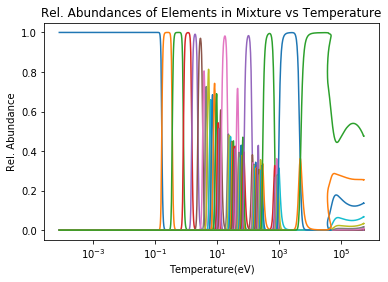

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\prana\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


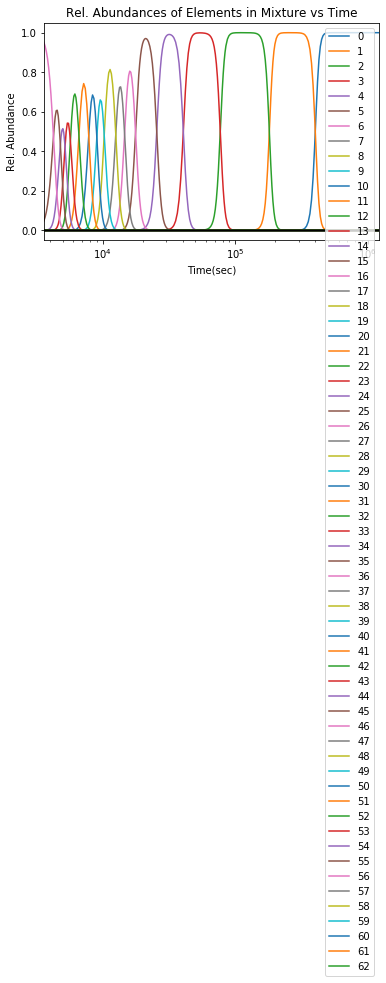

IndexError: list index out of range

In [11]:
Y = YI[61]
#Temperature
Ytot = np.sum(Y,1)
#Ytot[18] = 1e-309
for i in range(len(Y[0])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot,label = i)
    #plt.semilogx(kbEvpGK*np.array(full_temp),bad,color = 'black')
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Rel. Abundance")
    plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
#plt.legend()
plt.show()

#Time
for i in range(len(Y[0])):
    plt.semilogx(np.array(time),(Y[:,i])/Ytot,label = i)
    plt.semilogx(np.array(time),bad,color = 'black')
    plt.xlabel("Time(sec)")
    plt.ylabel("Rel. Abundance")
    plt.title("Rel. Abundances of Elements in Mixture vs Time")
    plt.xlim([3600,1.21e+6]) #1 hr to 2 weeks in sec    
plt.legend()
plt.show()

Y2 = abundance_using_Ye_tot[61]
Ytot2 = np.sum(Y2,1)
for i in range(len(Y2[0])):
    plt.semilogx(np.array(time),(Y2[:,i])/Ytot2)
    plt.semilogx(np.array(time),bad,color = 'black')
    plt.xlabel("Time(sec)")
    plt.ylabel("Rel. Abundance")
    plt.title("Rel. Abundances of Elements in Mixture vs Time w/Ye_f = Ye_tot")
    plt.xlim([3600,1.21e+6]) #1 hr to 2 weeks in sec
plt.show()


Text(0, 0.5, 'Diff')

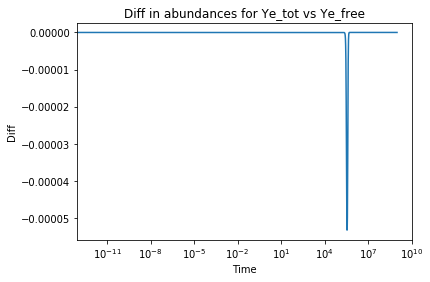

In [14]:
diff = np.array(Y[:,0])-np.array(Y2[:,0])
plt.semilogx(time,diff)
plt.title('Diff in abundances for Ye_tot vs Ye_free')
plt.xlabel('Time')
plt.ylabel('Diff')

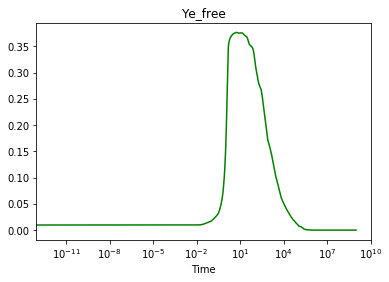

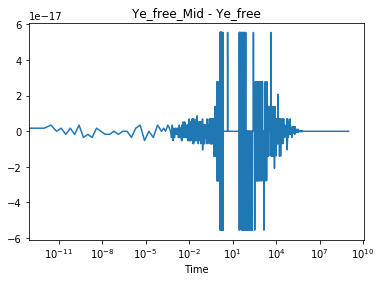

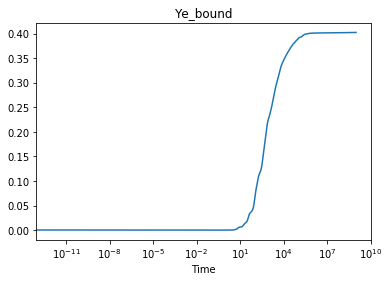

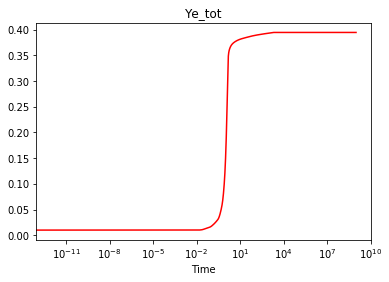

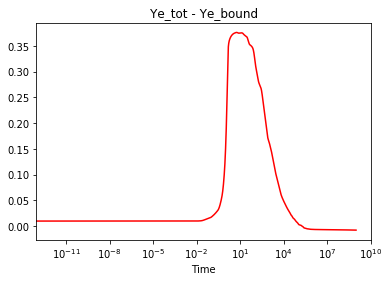

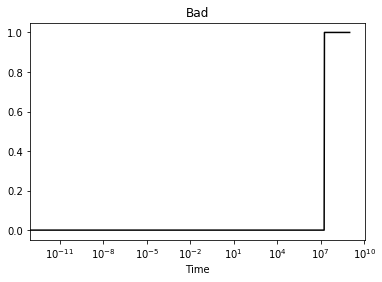

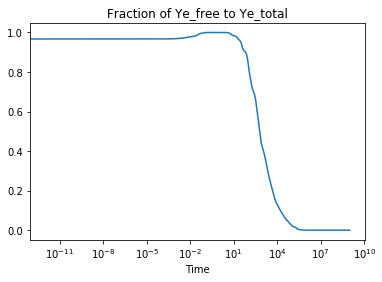

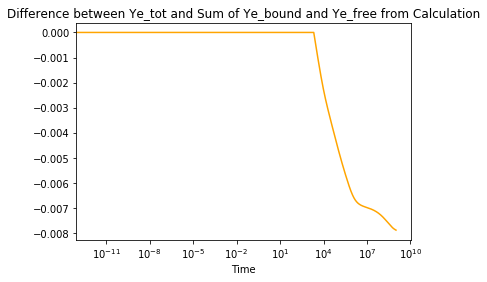

0
0     1.040834e-17
1     2.602085e-17
2     2.775558e-17
3     1.908196e-17
4     1.214306e-17
5     2.949030e-17
6     1.734723e-17
7     1.561251e-17
8     2.081668e-17
9     1.734723e-17
10    1.561251e-17
11    2.081668e-17
12    1.734723e-17
13    2.081668e-17
14    2.602085e-17
15    5.204170e-18
16    5.204170e-18
17    2.602085e-17
18    8.673617e-18
19    2.081668e-17
20    6.938894e-18
21    1.214306e-17
22    2.775558e-17
23    2.255141e-17
24    1.734723e-18
25   -1.734723e-18
26    1.561251e-17
27   -2.949030e-17
28    5.204170e-18
29    1.040834e-17
...            ...
2168 -7.633148e-03
2169 -7.644078e-03
2170 -7.654545e-03
2171 -7.664573e-03
2172 -7.674182e-03
2173 -7.689591e-03
2174 -7.703949e-03
2175 -7.717336e-03
2176 -7.729827e-03
2177 -7.741489e-03
2178 -7.752384e-03
2179 -7.762569e-03
2180 -7.772097e-03
2181 -7.781015e-03
2182 -7.790965e-03
2183 -7.800173e-03
2184 -7.808704e-03
2185 -7.816615e-03
2186 -7.824258e-03
2187 -7.831339e-03
2188 -7.837905e-03
2189 -7.844002e-03
2190 -7.849670e-03
2191 -7.854946e-03
2192 -7.859863e-03
2193 -7.864451e-03
2194 -7.868739e-03
2195 -7.872751e-03
2196 -7.876512e-03
2197 -7.879341e-03

[2198 rows x 1 columns]

In [15]:
#plotting Ye_free, Ye_tot, and the bad array
plt.semilogx(time,Ye_free[0],color = 'green') #Ye_free[0] is only because the shape of Ye_free is (1,2198) for some reason
plt.title('Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_f_Mid[0]) - np.array(Ye_free[0]))
plt.title('Ye_free_Mid - Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,Ye_bound[0])
plt.xlabel('Time')
plt.title('Ye_bound')
plt.show()

plt.semilogx(time,Ye_tot,color = 'red')
plt.title('Ye_tot')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,Ye_tot - Ye_bound[0],color = 'red')
plt.title('Ye_tot - Ye_bound')
plt.xlabel('Time')
plt.show()

plt.title('Bad')
plt.semilogx(time,bad,color = 'black')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_free[0])/np.array(Ye_tot))
plt.title('Fraction of Ye_free to Ye_total')
plt.xlabel('Time')
plt.show()

difference = np.array(Ye_tot) - (np.array(Ye_bound[0]) + np.array(Ye_free[0]))

plt.semilogx(time,difference,color = 'orange')
plt.title('Difference between Ye_tot and Sum of Ye_bound and Ye_free from Calculation')
plt.xlabel('Time')
plt.show()
pd.DataFrame(difference)

In [16]:
first_instance = 0
for i in range(len(bad)):
    if bad[i] == 1:
        first_instance = i
        break
first_instance

2114

In [17]:
print(Ytot[10])
print(np.max(YI[61][10]))
(YI[61][10][62])


4.627848343755342e-65
2.2033999751203625e-65


2.2033999751203625e-65

In [18]:
YI[61][10]

array([7.76396679e-85, 1.61315853e-84, 3.35170561e-84, 6.96376662e-84,
       1.44679619e-83, 3.00574972e-83, 6.24421523e-83, 1.29714784e-82,
       2.69456391e-82, 5.59716595e-82, 1.16260879e-81, 2.41480118e-81,
       5.01539105e-81, 1.04160694e-80, 2.16314749e-80, 4.49213129e-80,
       9.32809869e-80, 1.93639138e-79, 4.01944668e-79, 8.34273266e-79,
       1.73148393e-78, 3.59334047e-78, 7.45665131e-78, 1.54722098e-77,
       3.21016430e-77, 6.65991337e-77, 1.38158084e-76, 2.86519828e-76,
       5.94154600e-76, 1.23199031e-75, 2.55434175e-75, 5.29524477e-75,
       1.09762615e-74, 2.27475075e-74, 4.71380449e-74, 9.74940884e-74,
       2.01606816e-73, 4.16817195e-73, 8.61581122e-73, 1.78056443e-72,
       3.67901045e-72, 7.59951584e-72, 1.56945648e-71, 3.24052371e-71,
       6.68942425e-71, 1.38008319e-70, 2.84669097e-70, 5.87064083e-70,
       1.21045427e-69, 2.49457319e-69, 5.13986513e-69, 1.05859534e-68,
       2.17980861e-68, 4.43815607e-68, 9.03153739e-68, 1.83683653e-67,
      

Text(0, 0.5, 'Abundance')

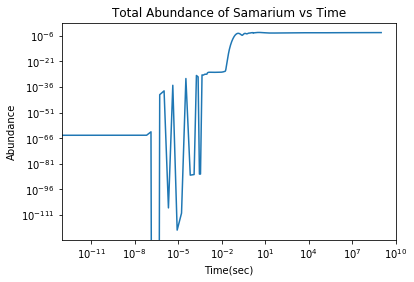

In [14]:
#Graphing The Sm abundance vs time. Remove the comment below to show graphical overlap
plt.loglog(time,elemental[61])
#plt.loglog(time,Ytot,color = 'red')
#plt.xlim(3600,1209600)
plt.title('Total Abundance of Samarium vs Time')
plt.xlabel('Time(sec)')
plt.ylabel('Abundance')

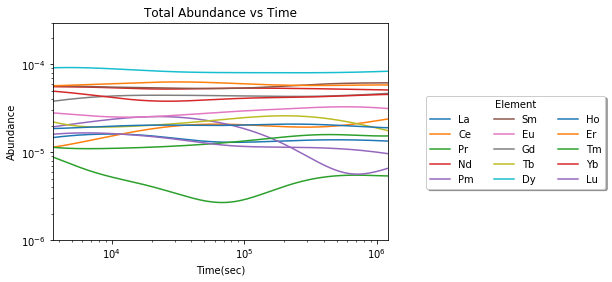

In [51]:
lanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
for i in range(56,71):
    plt.loglog(time,elemental[i],label = lanthanide_names[i-56])
    plt.xlim(3600,1209600)
    plt.ylim(1e-6,3e-4)
    plt.title('Total Abundance vs Time')
    plt.xlabel('Time(sec)')
    plt.ylabel('Abundance')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.45),shadow = True,fancybox = True,title = 'Element',ncol = 3)

In [ ]:
#Understanding the difference between Ytot and the elemental abundances from skynet
diff = (np.array(elemental[61]) - np.array(Ytot))/elemental[61]
indices = []
values = []
for i in range(len(diff)):
    if diff[i] != 0:
        indices.append(i)
        values.append(diff[i])

print('There are these many values that differ: ',len(values))
plt.semilogx(time,np.abs(diff))
plt.xlabel('Time')
plt.title('Relative Differences of Abundances Between Elemental and Ytot')
plt.show()

In [23]:
'''for i in range(104):
    time_start = process_time()
    YI = abundance_calculation(np.arange(1,1+i,1))
    time_elapsed = process_time() - time_start
    file = 'calculation' + str((1+i)) + '.txt'
    with open(file, 'wb') as fp:
        pickle.dump(YI, fp)
    print(time_elapsed,' sec for this calculation')'''

"for i in range(104):\n    time_start = process_time()\n    YI = abundance_calculation(np.arange(1,1+i,1))\n    time_elapsed = process_time() - time_start\n    file = 'calculation' + str((1+i)) + '.txt'\n    with open(file, 'wb') as fp:\n        pickle.dump(YI, fp)\n    print(time_elapsed,' sec for this calculation')"

In [24]:
#Call to function to generate data. Also, calculate time it takes.

'''time_start = process_time()
YI = abundance_calculation(np.arange(1,104,1))
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')

#with open('All_class_adjusted.txt', 'wb') as fp:
    #pickle.dump(YI, fp)'''

'time_start = process_time()\nYI = abundance_calculation(np.arange(1,104,1))\ntime_elapsed = (process_time() - time_start)\nprint("This calculation took",time_elapsed,\' sec\')\n\n#with open(\'All_class_adjusted.txt\', \'wb\') as fp:\n    #pickle.dump(YI, fp)'

In [25]:
#This is the calculation to make the time plot. Currently, it is commented out for convenience
'''times = []
elements = np.arange(1,104,1)

for i in elements:
    time_start = process_time()
    YI = abundance_calculation([i])
    times.append(process_time() - time_start)
    
plt.plot(elements,times)
plt.xlabel('Element Number')
plt.ylabel('Times(sec)')
plt.title('Calculation Times for Abundances')
plt.grid()
plt.savefig('times.png')'''

"times = []\nelements = np.arange(1,104,1)\n\nfor i in elements:\n    time_start = process_time()\n    YI = abundance_calculation([i])\n    times.append(process_time() - time_start)\n    \nplt.plot(elements,times)\nplt.xlabel('Element Number')\nplt.ylabel('Times(sec)')\nplt.title('Calculation Times for Abundances')\nplt.grid()\nplt.savefig('times.png')"

In [26]:
#Beginning of Lanthanide Analysis

In [27]:
#This cell exists to make the entire lanthanide calculation. 
time_start = process_time()
YI,bad,Ye_free,Ye_bound,Ye_f_Mid,abundance_using_Ye_tot = abundance_calculation(np.arange(58,72,1))
time_elapsed = process_time() - time_start
time_elapsed

C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:133: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:134: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Fixing_Cutoff\saha_mult.py:145: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


32.15625

In [28]:
'''with open("Lanthanides.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)'''

'with open("Lanthanides.txt", "rb") as fp:   # Unpickling\n      YI = pickle.load(fp)'

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


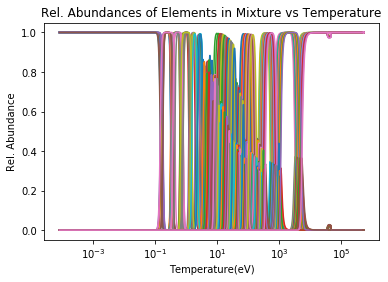

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


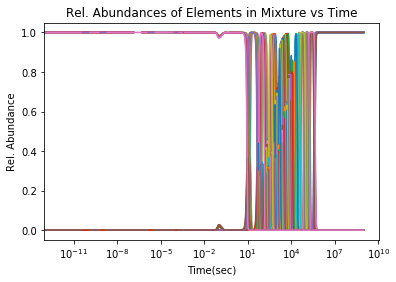

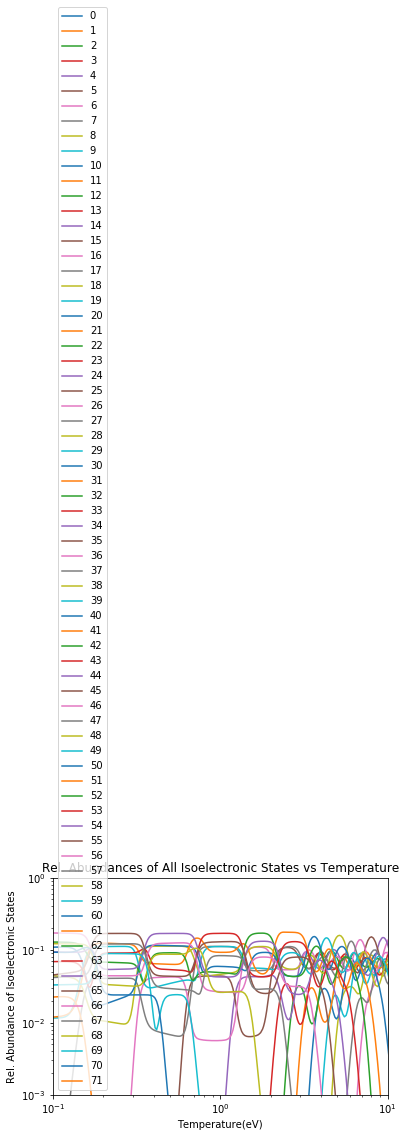

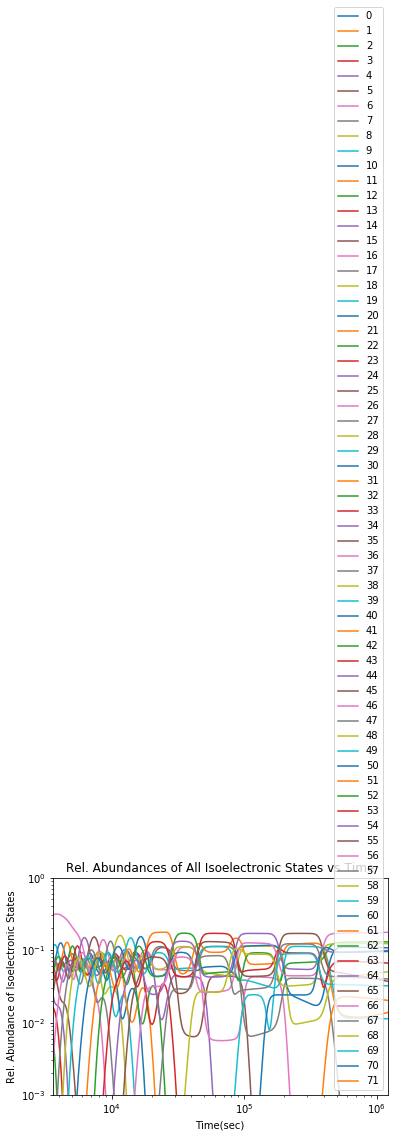

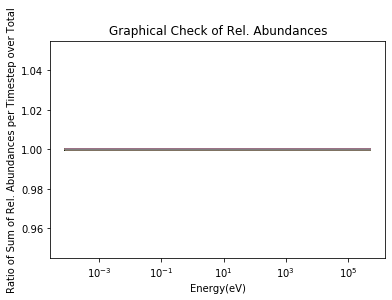

This calculation took 17.609375  sec to graph


In [29]:
plotter(YI)

This is the graph for element  58 so there are  59  ionization states graphed


C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


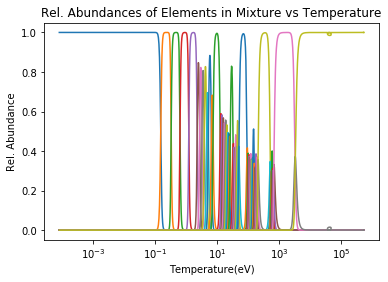

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


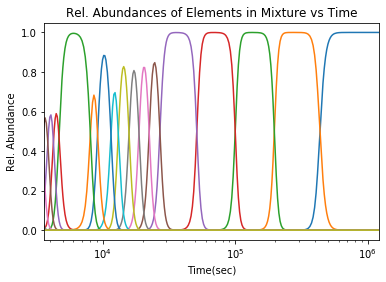

This is the graph for element  59 so there are  60  ionization states graphed


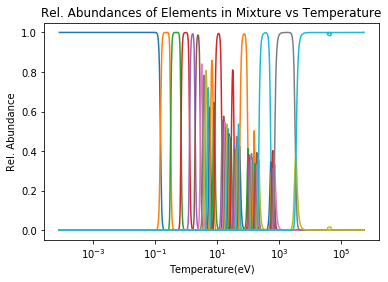

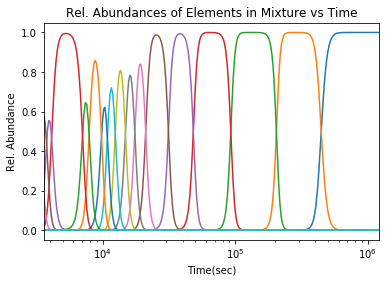

This is the graph for element  60 so there are  61  ionization states graphed


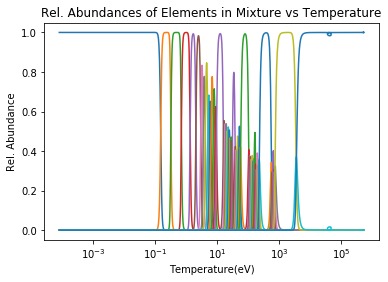

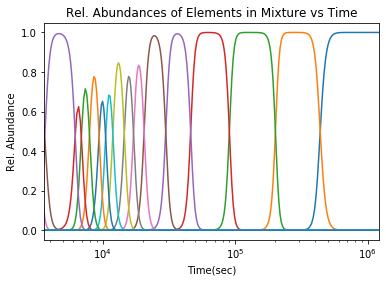

This is the graph for element  61 so there are  62  ionization states graphed


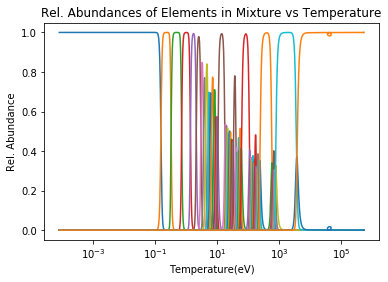

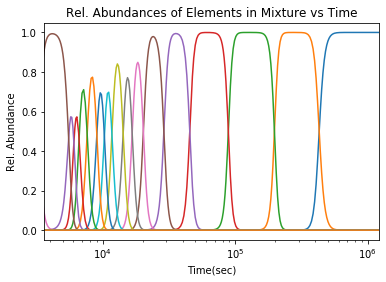

This is the graph for element  62 so there are  63  ionization states graphed


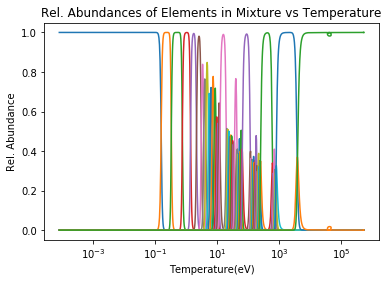

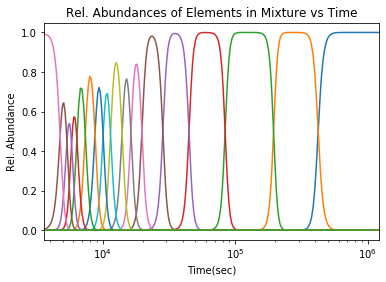

This is the graph for element  63 so there are  64  ionization states graphed


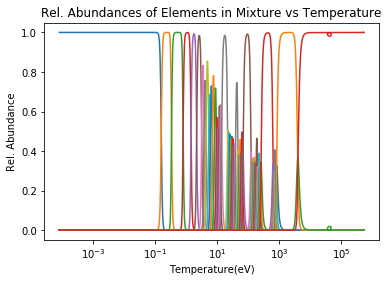

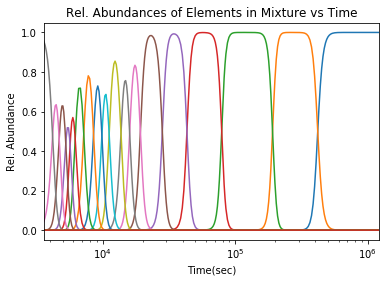

This is the graph for element  64 so there are  65  ionization states graphed


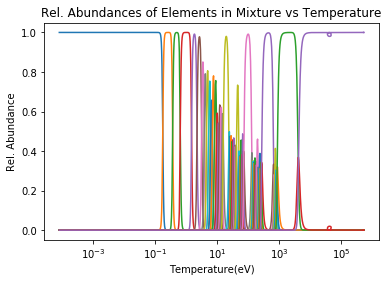

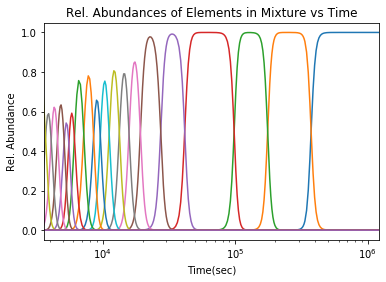

This is the graph for element  65 so there are  66  ionization states graphed


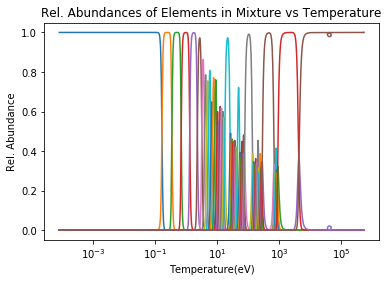

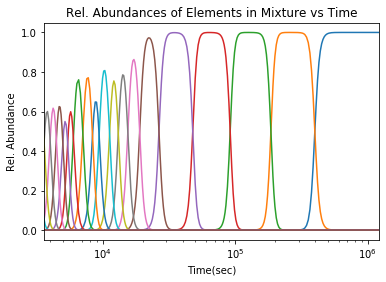

This is the graph for element  66 so there are  67  ionization states graphed


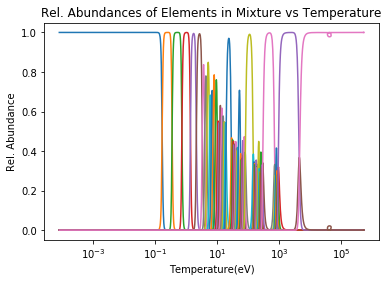

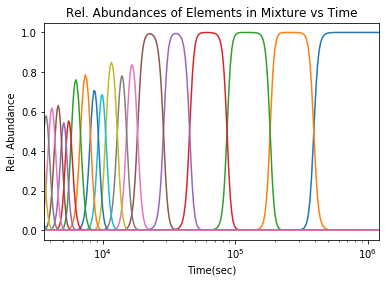

This is the graph for element  67 so there are  68  ionization states graphed


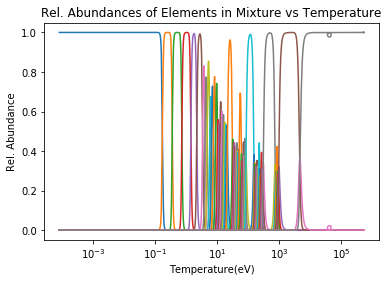

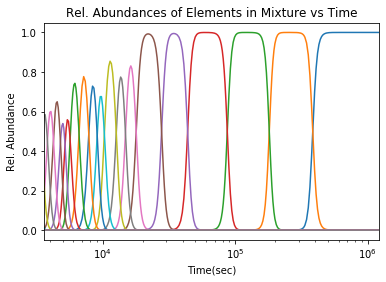

This is the graph for element  68 so there are  69  ionization states graphed


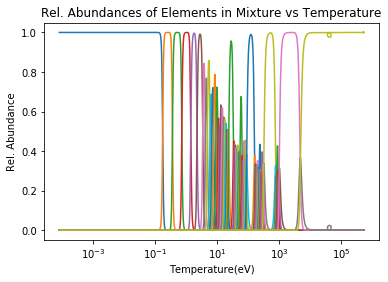

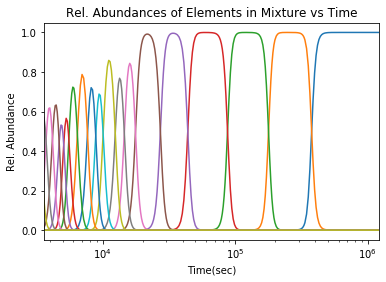

This is the graph for element  69 so there are  70  ionization states graphed


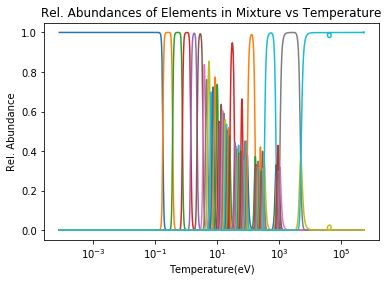

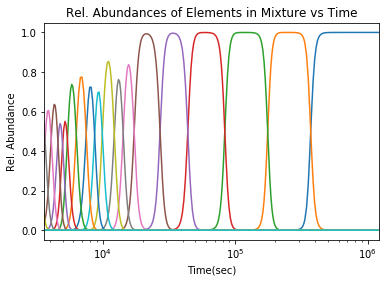

This is the graph for element  70 so there are  71  ionization states graphed


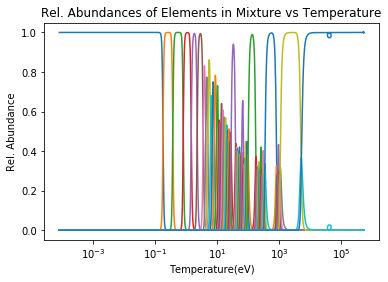

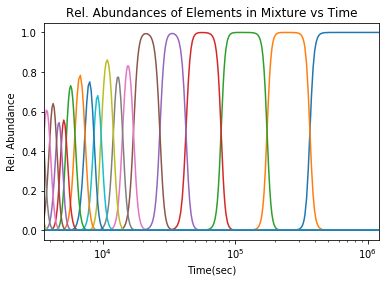

This is the graph for element  71 so there are  72  ionization states graphed


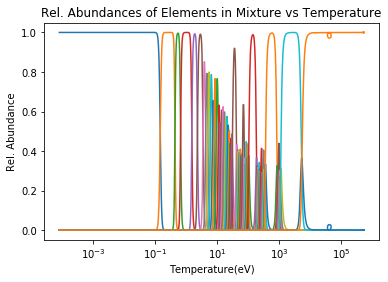

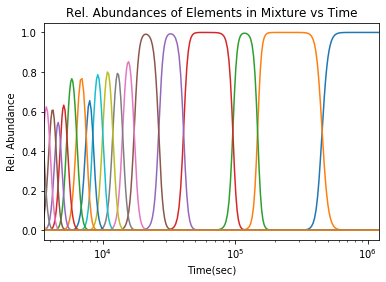

In [30]:
#Just plotting all the lanthanide abundances seperately
element_num = 58 #Z of first lanthanide
for Y in YI:
    #Temperature
    Ytot = np.sum(Y,1)
    print('This is the graph for element ',element_num,'so there are ',element_num+1,' ionization states graphed')
    for i in range(len(Y[0])):
        plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot)
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    plt.show()
    
    #Time
    for i in range(len(Y[0])):
        plt.semilogx(np.array(time),(Y[:,i])/Ytot)
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Time")
        plt.xlim([3600,1.21e+6])
    element_num+=1
    plt.show()
        

In [31]:
isotopic_abundances,potentials = initialization(np.arange(58,72,1))

This is the abundance graph of element:  58


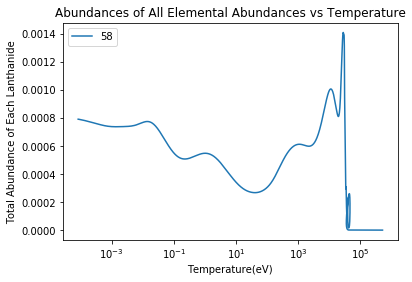

This is the abundance graph of element:  59


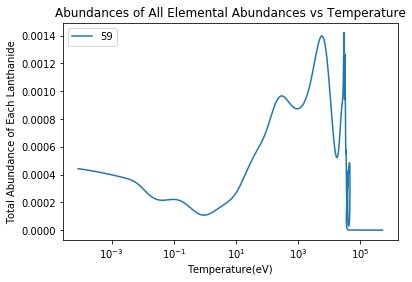

This is the abundance graph of element:  60


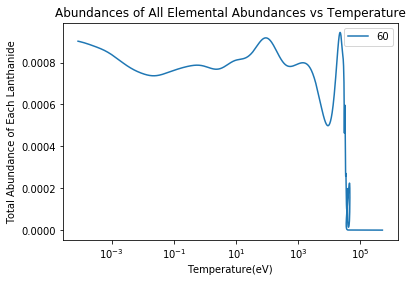

This is the abundance graph of element:  61


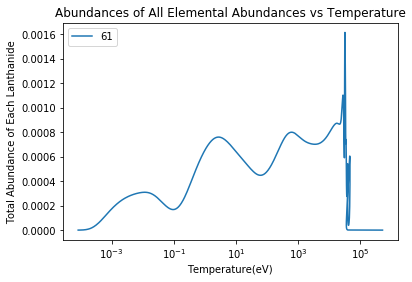

This is the abundance graph of element:  62


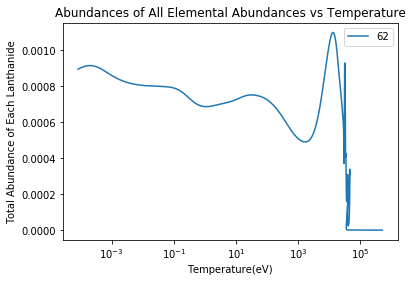

This is the abundance graph of element:  63


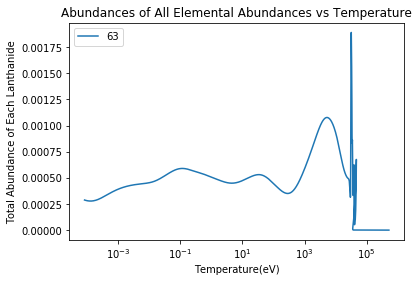

This is the abundance graph of element:  64


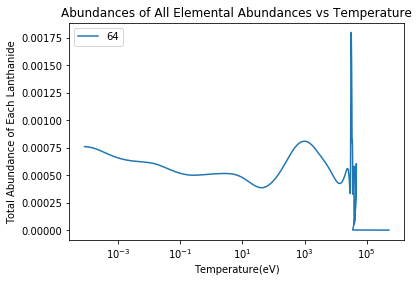

This is the abundance graph of element:  65


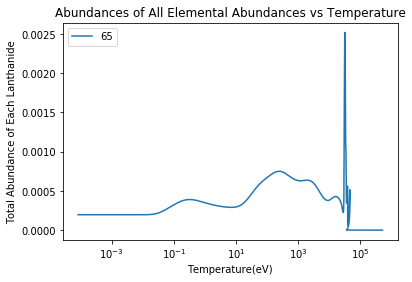

This is the abundance graph of element:  66


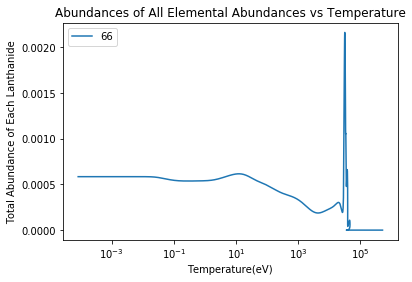

This is the abundance graph of element:  67


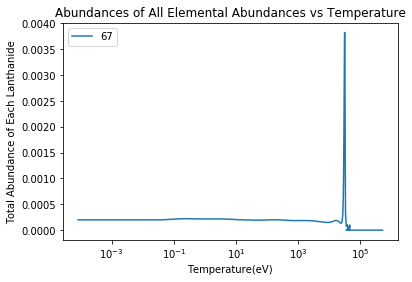

This is the abundance graph of element:  68


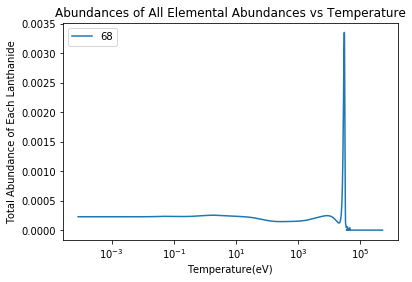

This is the abundance graph of element:  69


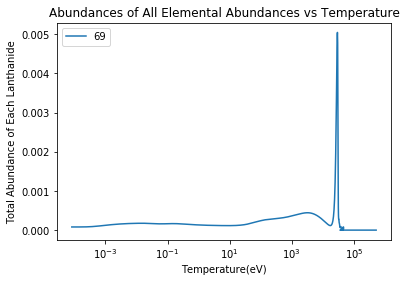

This is the abundance graph of element:  70


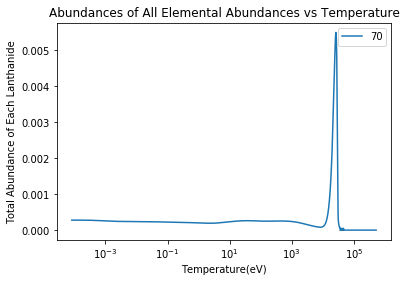

This is the abundance graph of element:  71


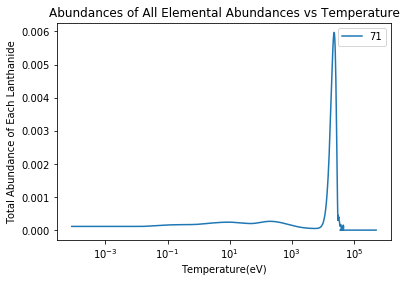

In [32]:
for i in range(len(isotopic_abundances)):
    print('This is the abundance graph of element: ',(i+58))
    Ytot_isotopic = np.sum(isotopic_abundances[i])
    plt.semilogx(kbEvpGK*np.array(full_temp),isotopic_abundances[i]/Ytot_isotopic,label = (i+58))
    plt.legend()
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Total Abundance of Each Lanthanide")
    plt.title("Abundances of All Elemental Abundances vs Temperature")
    plt.show()

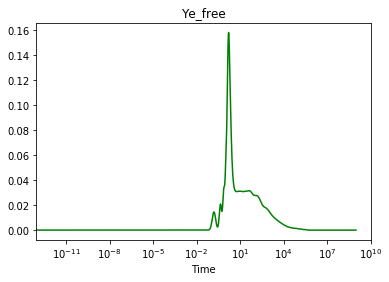

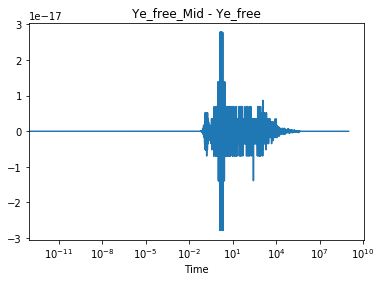

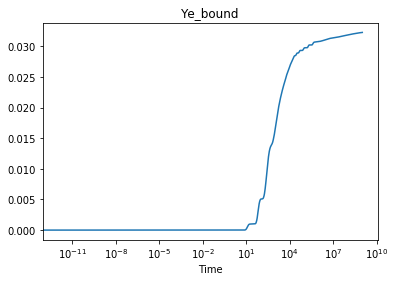

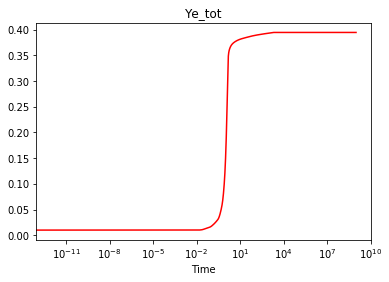

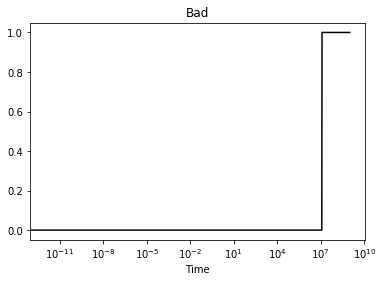

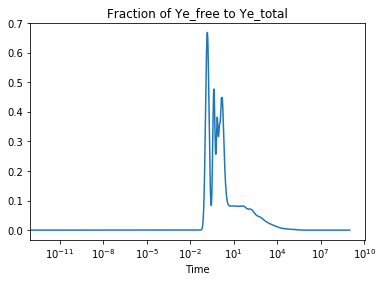

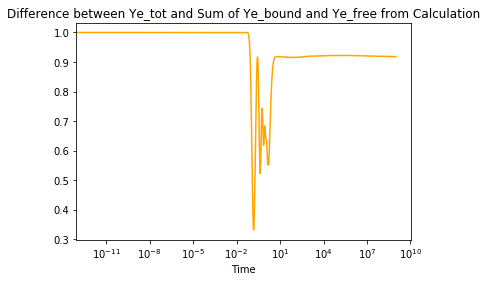

0
0     0.010000
1     0.010000
2     0.010000
3     0.010000
4     0.010000
5     0.010000
6     0.010000
7     0.010000
8     0.010000
9     0.010000
10    0.010000
11    0.010000
12    0.010000
13    0.010000
14    0.010000
15    0.010000
16    0.010000
17    0.010000
18    0.010000
19    0.010000
20    0.010000
21    0.010000
22    0.010000
23    0.010000
24    0.010000
25    0.010000
26    0.010000
27    0.010000
28    0.010000
29    0.010001
...        ...
2168  0.362443
2169  0.362436
2170  0.362429
2171  0.362423
2172  0.362417
2173  0.362407
2174  0.362398
2175  0.362390
2176  0.362382
2177  0.362374
2178  0.362367
2179  0.362360
2180  0.362354
2181  0.362347
2182  0.362341
2183  0.362334
2184  0.362328
2185  0.362322
2186  0.362317
2187  0.362311
2188  0.362306
2189  0.362302
2190  0.362297
2191  0.362293
2192  0.362289
2193  0.362285
2194  0.362282
2195  0.362278
2196  0.362275
2197  0.362272

[2198 rows x 1 columns]

In [33]:
#Im doing this Ye analysis, but for the lanthanides

plt.semilogx(time,Ye_free[0],color = 'green') #Ye_free[0] is only because the shape of Ye_free is (1,2198) for some reason
plt.title('Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_f_Mid[0]) - np.array(Ye_free[0]))
plt.title('Ye_free_Mid - Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,Ye_bound[0])
plt.xlabel('Time')
plt.title('Ye_bound')
plt.show()


plt.semilogx(time,Ye_tot,color = 'red')
plt.title('Ye_tot')
plt.xlabel('Time')
plt.show()

plt.title('Bad')
plt.semilogx(time,bad,color = 'black')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_free[0])/np.array(Ye_tot))
plt.title('Fraction of Ye_free to Ye_total')
plt.xlabel('Time')
plt.show()

difference = np.array(Ye_tot) - (np.array(Ye_bound[0]) + np.array(Ye_free[0]))

plt.semilogx(time,difference/np.array(Ye_tot),color = 'orange')
plt.title('Difference between Ye_tot and Sum of Ye_bound and Ye_free from Calculation')
plt.xlabel('Time')
plt.show()
pd.DataFrame(difference)

In [ ]:
#End of Lanthanide Analysis

In [ ]:
#Beginning of Lanthanide and Actinide Analysis

In [35]:
#This cell exists to make the entire lanthanide+actinide calculation. 
time_start = process_time()
YI,bad,Ye_free,Ye_bound,Ye_f_Mid,abundance_using_Ye_tot = abundance_calculation(np.arange(58,104,1))
time_elapsed = process_time() - time_start
time_elapsed

120.296875

In [36]:
'''with open("Lanthanides_Actinides.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)'''

'with open("Lanthanides_Actinides.txt", "rb") as fp:   # Unpickling\n      YI = pickle.load(fp)'

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


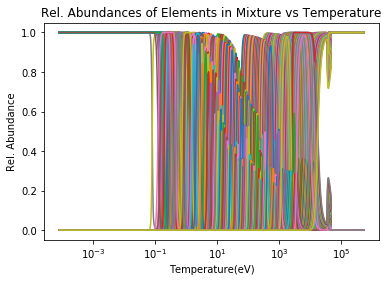

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


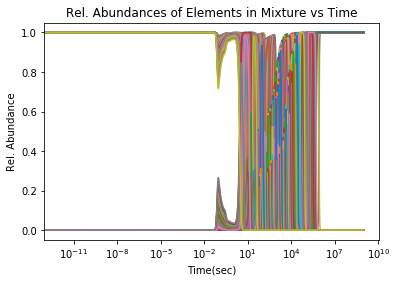

C:\Users\prana\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


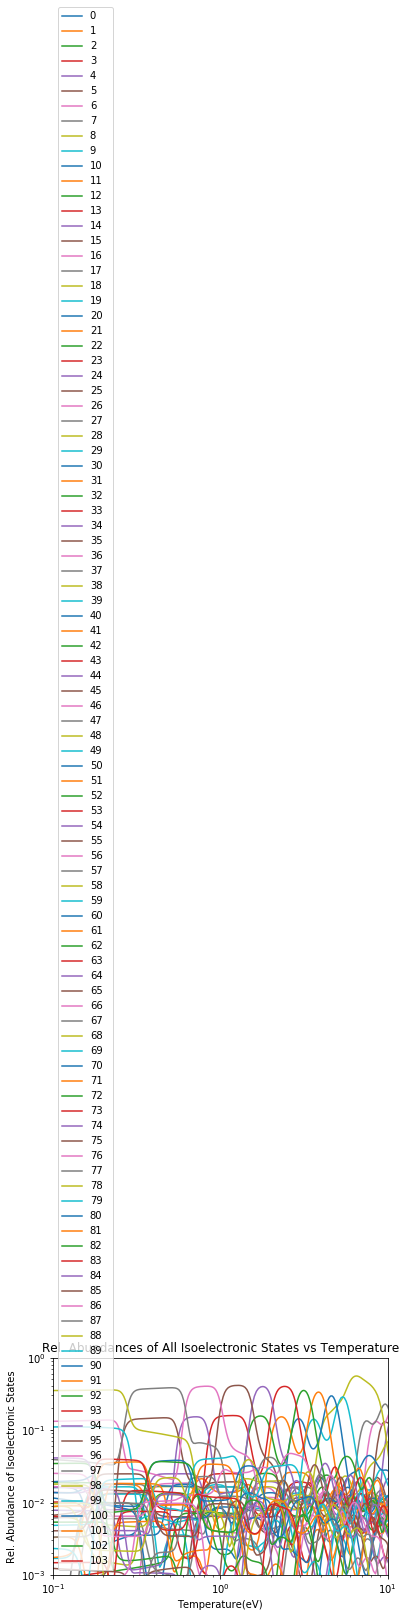

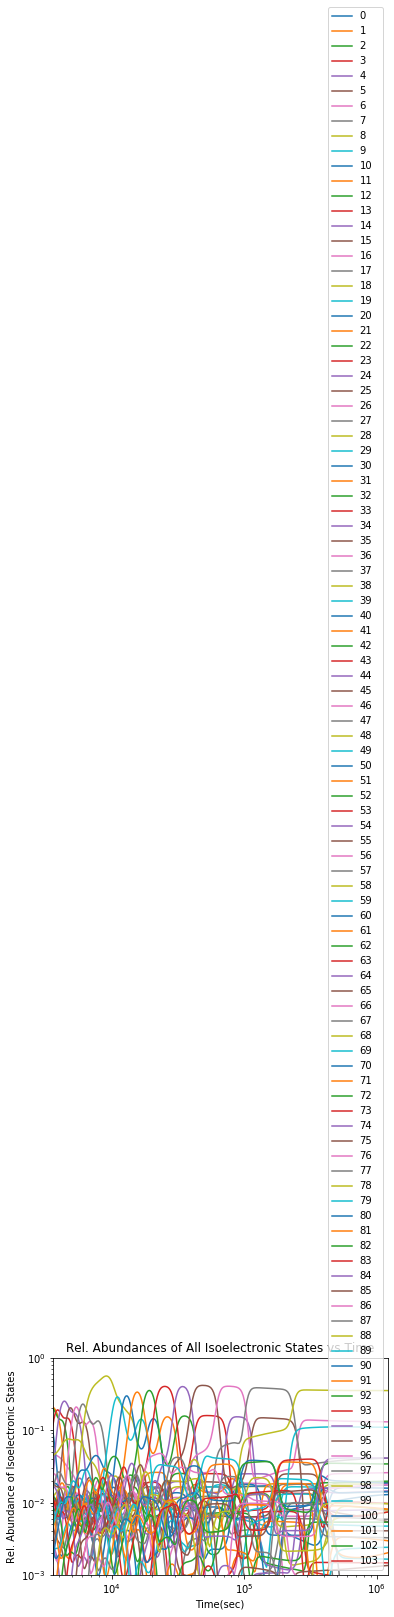

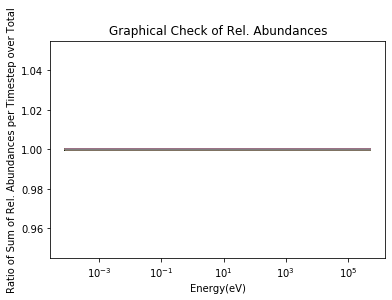

This calculation took 69.3125  sec to graph


In [37]:
plotter(YI)

This is the graph for element  58 so there are  59  ionization states graphed


C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


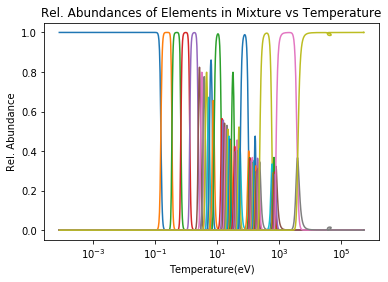

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


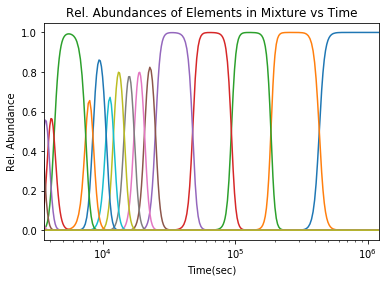

This is the graph for element  59 so there are  60  ionization states graphed


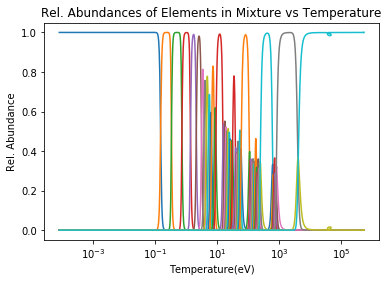

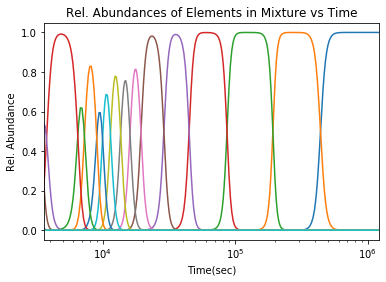

This is the graph for element  60 so there are  61  ionization states graphed


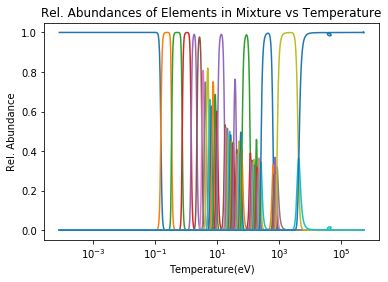

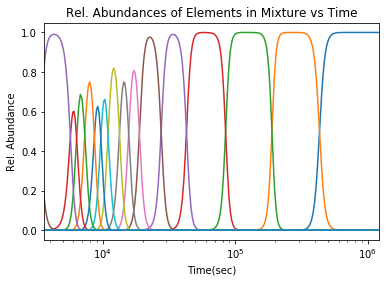

This is the graph for element  61 so there are  62  ionization states graphed


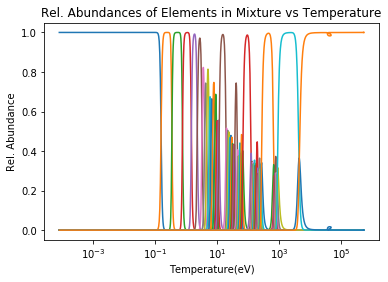

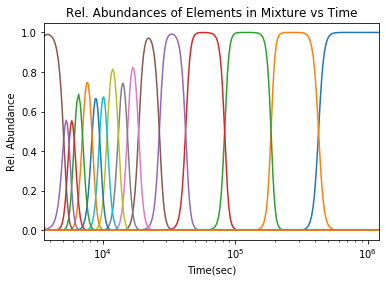

This is the graph for element  62 so there are  63  ionization states graphed


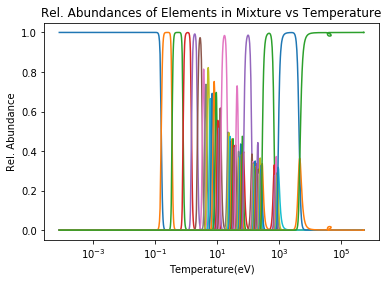

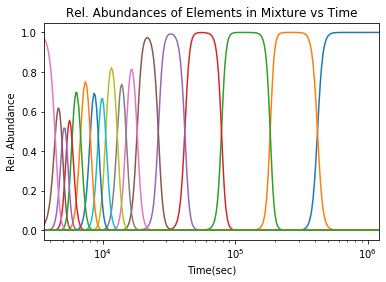

This is the graph for element  63 so there are  64  ionization states graphed


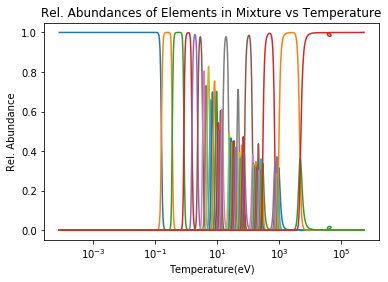

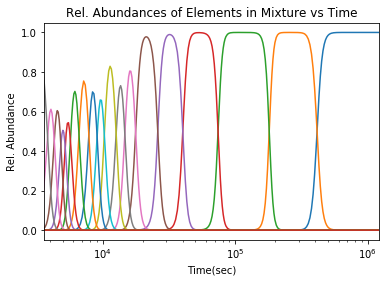

This is the graph for element  64 so there are  65  ionization states graphed


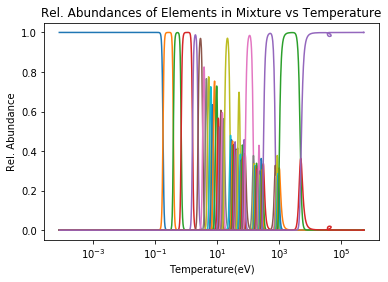

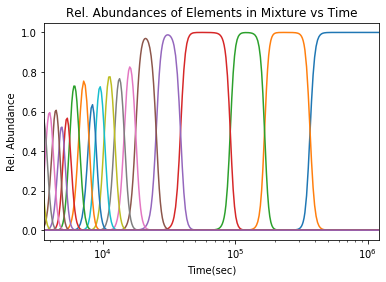

This is the graph for element  65 so there are  66  ionization states graphed


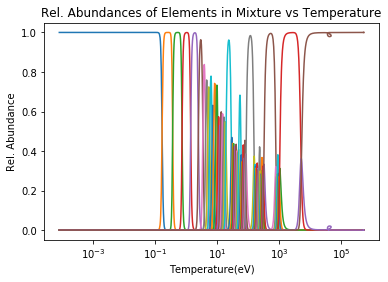

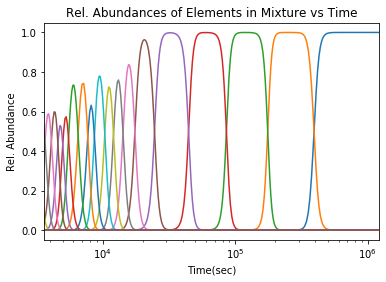

This is the graph for element  66 so there are  67  ionization states graphed


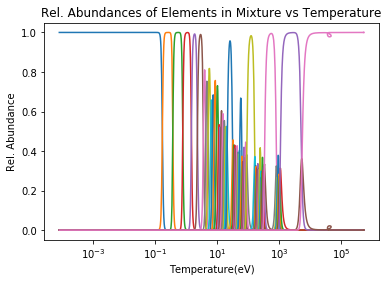

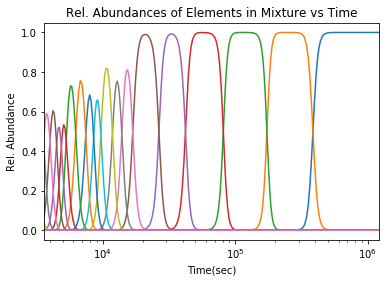

This is the graph for element  67 so there are  68  ionization states graphed


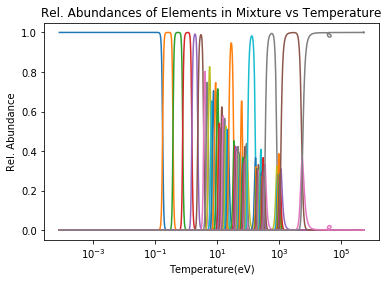

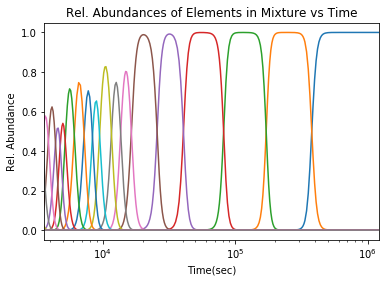

This is the graph for element  68 so there are  69  ionization states graphed


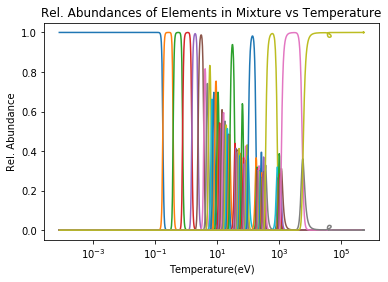

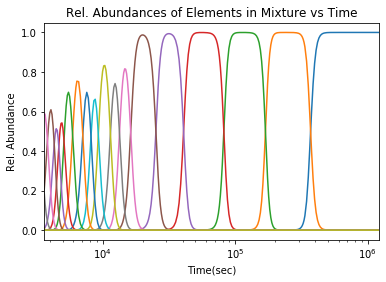

This is the graph for element  69 so there are  70  ionization states graphed


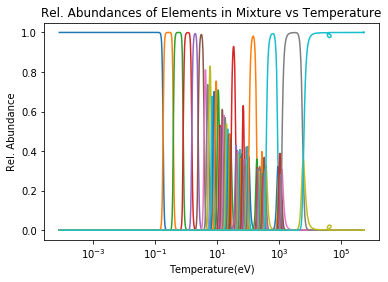

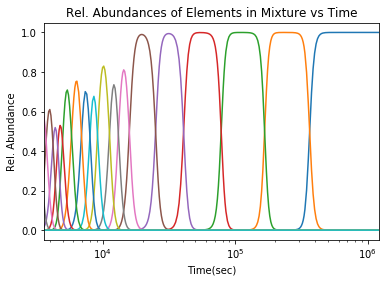

This is the graph for element  70 so there are  71  ionization states graphed


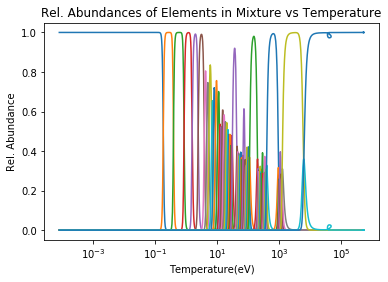

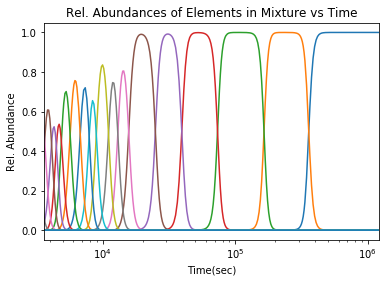

This is the graph for element  71 so there are  72  ionization states graphed


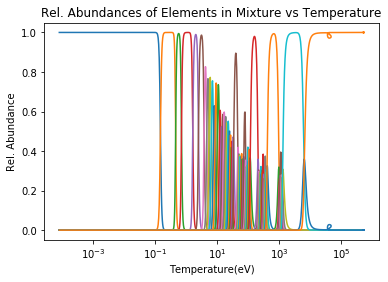

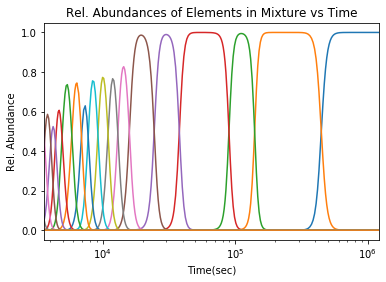

This is the graph for element  72 so there are  73  ionization states graphed


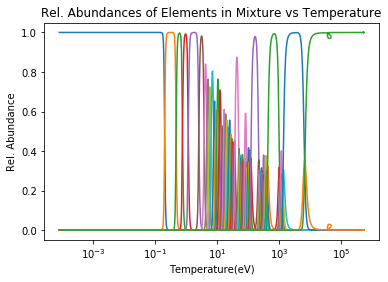

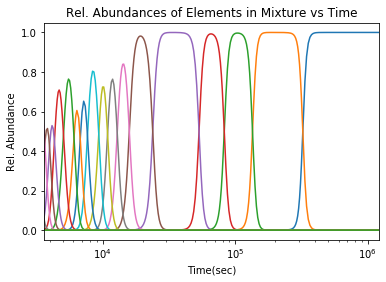

This is the graph for element  73 so there are  74  ionization states graphed


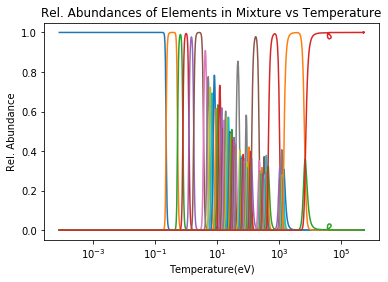

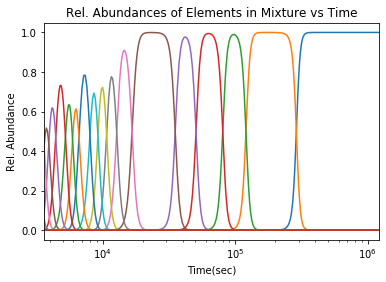

This is the graph for element  74 so there are  75  ionization states graphed


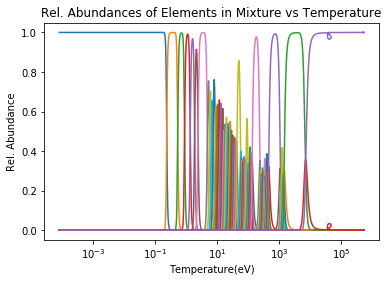

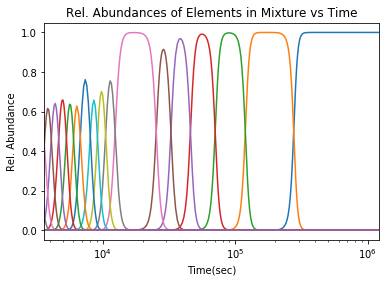

This is the graph for element  75 so there are  76  ionization states graphed


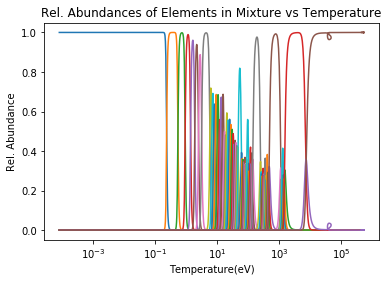

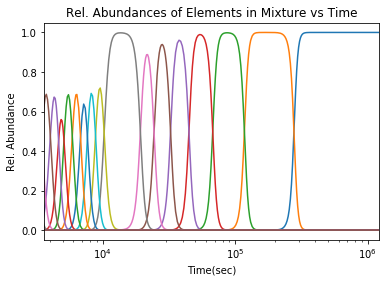

This is the graph for element  76 so there are  77  ionization states graphed


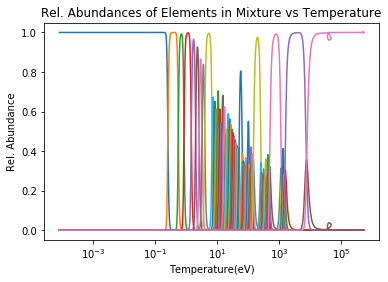

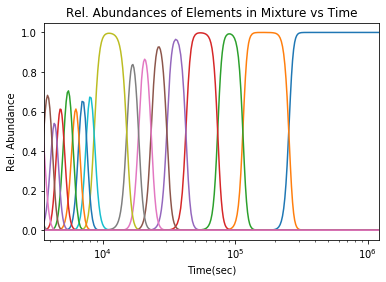

This is the graph for element  77 so there are  78  ionization states graphed


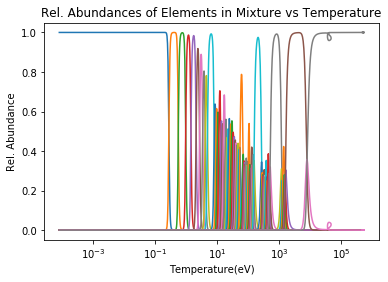

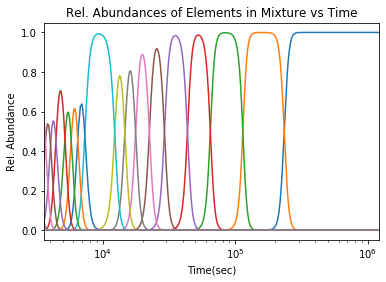

This is the graph for element  78 so there are  79  ionization states graphed


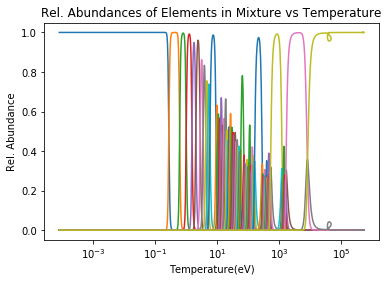

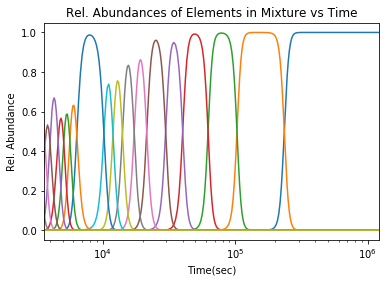

This is the graph for element  79 so there are  80  ionization states graphed


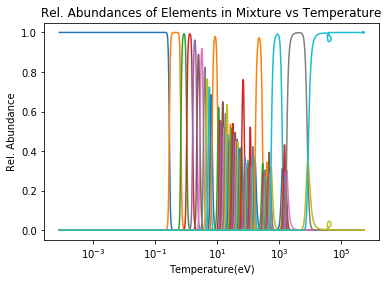

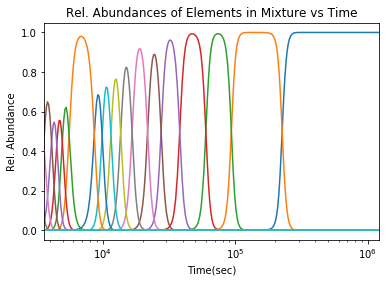

This is the graph for element  80 so there are  81  ionization states graphed


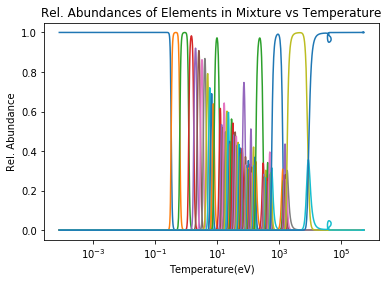

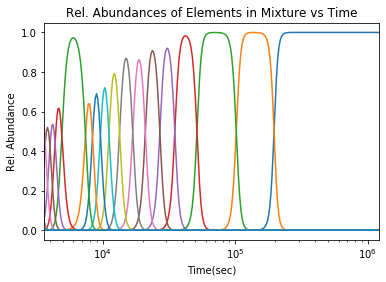

This is the graph for element  81 so there are  82  ionization states graphed


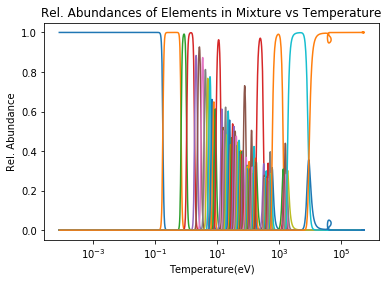

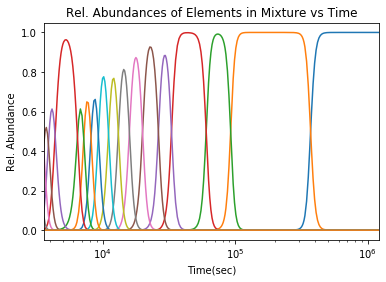

This is the graph for element  82 so there are  83  ionization states graphed


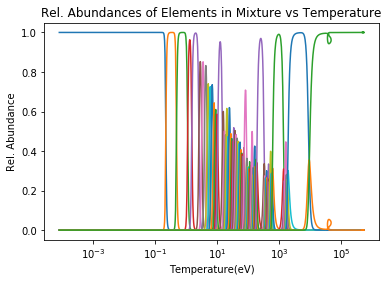

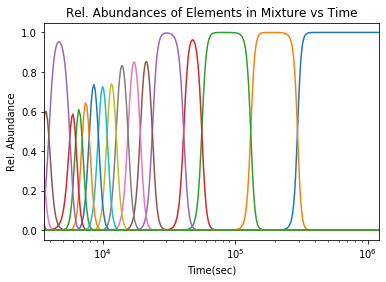

This is the graph for element  83 so there are  84  ionization states graphed


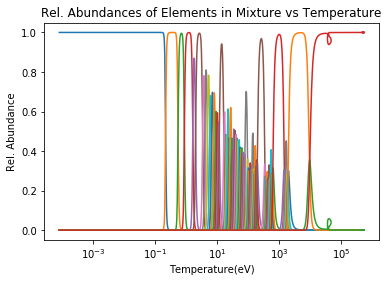

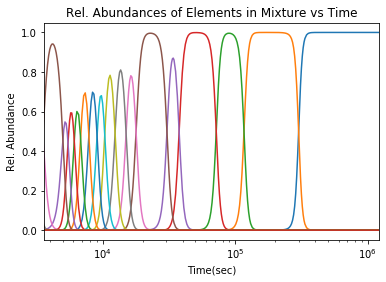

This is the graph for element  84 so there are  85  ionization states graphed


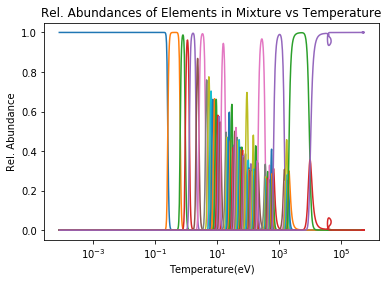

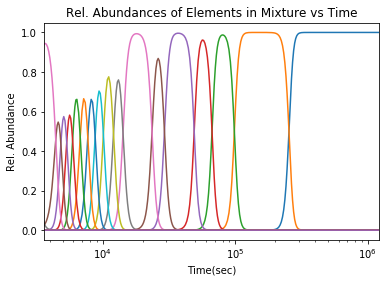

This is the graph for element  85 so there are  86  ionization states graphed


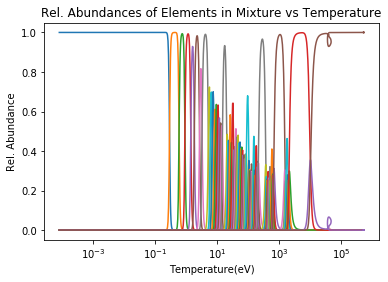

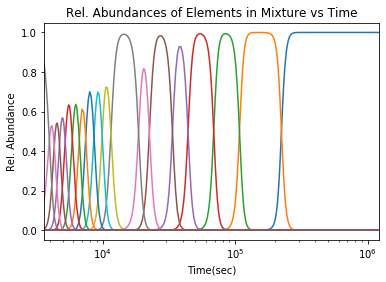

This is the graph for element  86 so there are  87  ionization states graphed


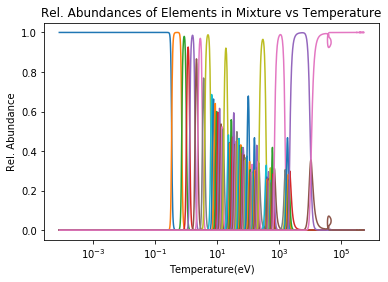

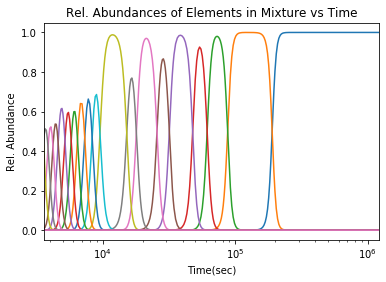

This is the graph for element  87 so there are  88  ionization states graphed


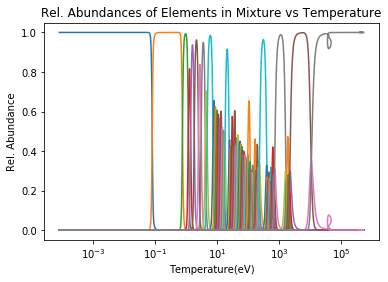

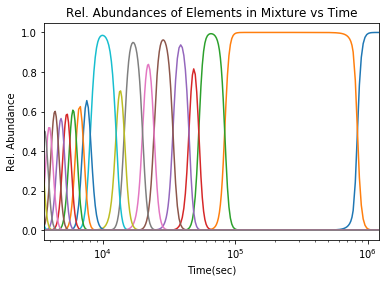

This is the graph for element  88 so there are  89  ionization states graphed


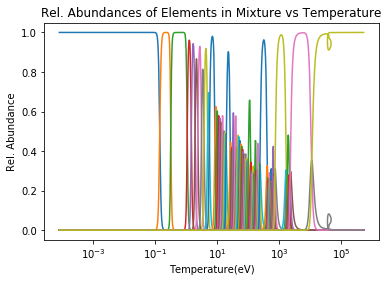

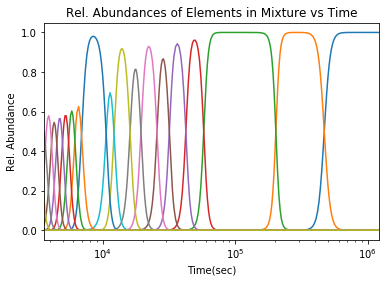

This is the graph for element  89 so there are  90  ionization states graphed


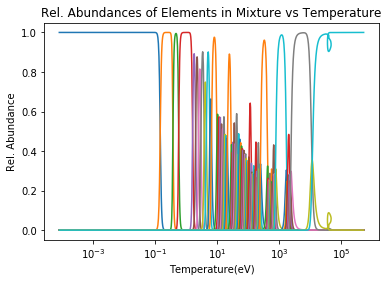

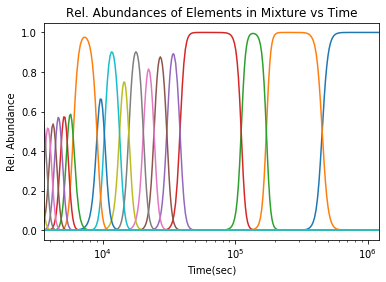

This is the graph for element  90 so there are  91  ionization states graphed


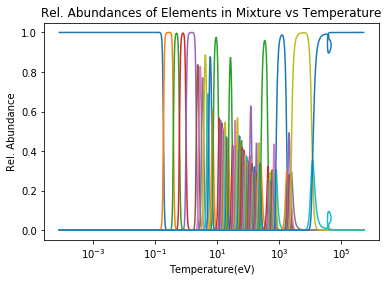

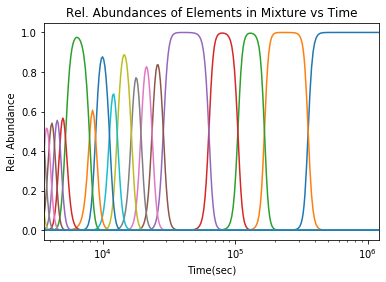

This is the graph for element  91 so there are  92  ionization states graphed


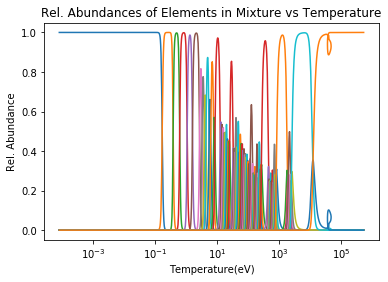

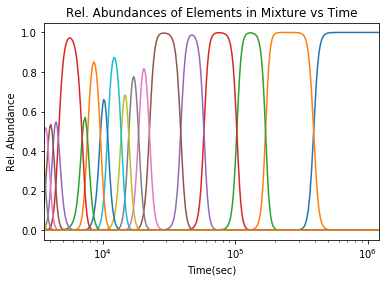

This is the graph for element  92 so there are  93  ionization states graphed


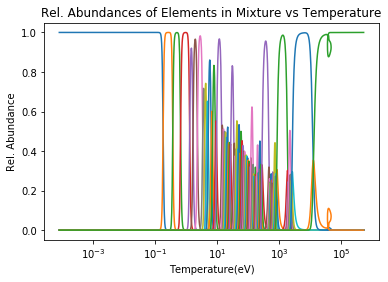

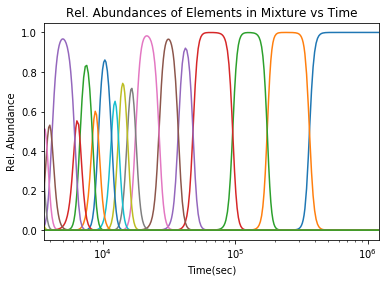

This is the graph for element  93 so there are  94  ionization states graphed


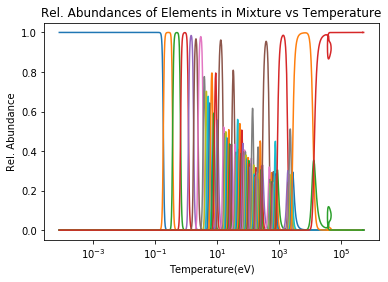

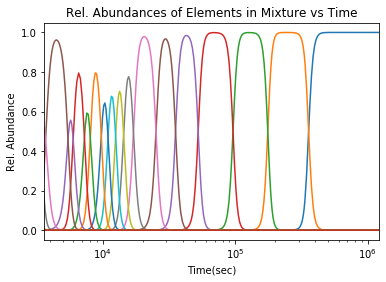

This is the graph for element  94 so there are  95  ionization states graphed


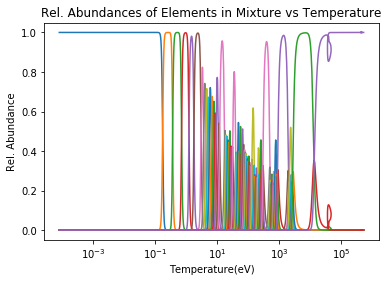

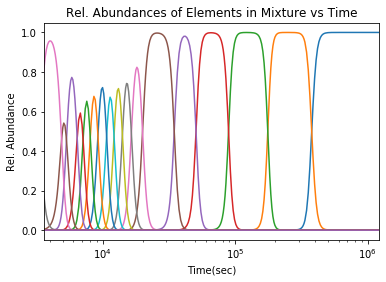

This is the graph for element  95 so there are  96  ionization states graphed


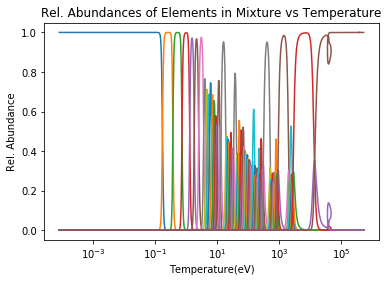

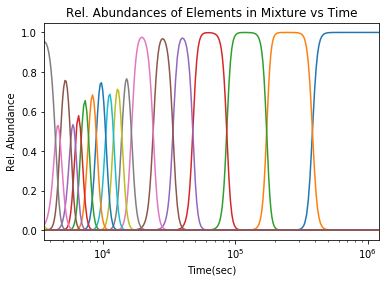

This is the graph for element  96 so there are  97  ionization states graphed


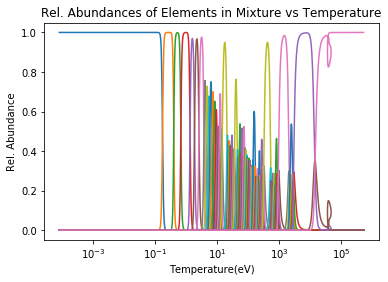

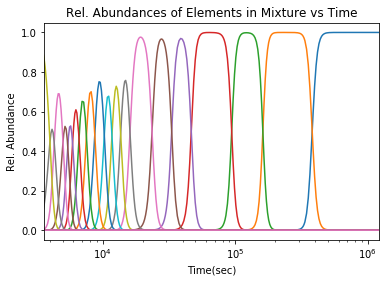

This is the graph for element  97 so there are  98  ionization states graphed


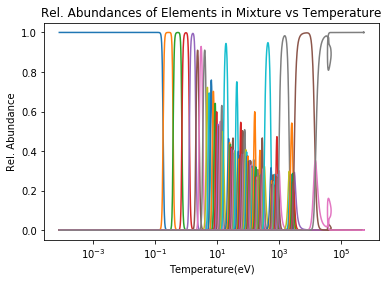

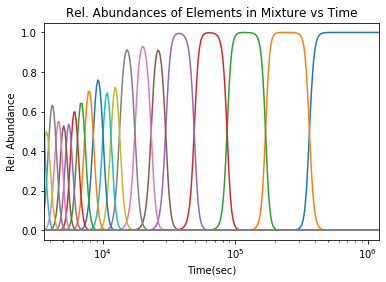

This is the graph for element  98 so there are  99  ionization states graphed


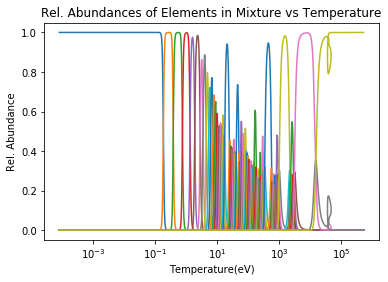

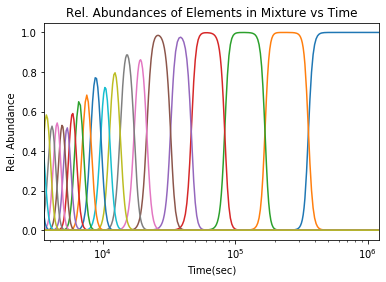

This is the graph for element  99 so there are  100  ionization states graphed


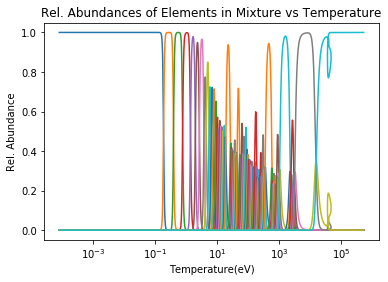

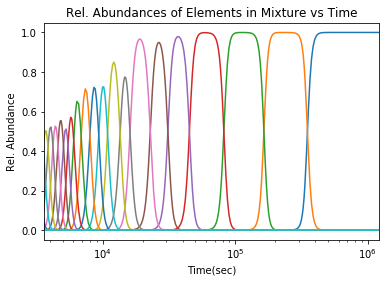

This is the graph for element  100 so there are  101  ionization states graphed


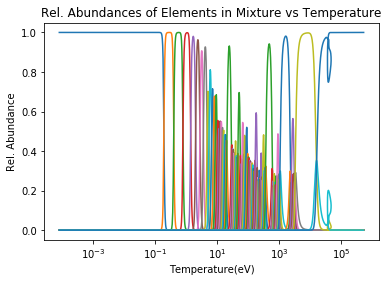

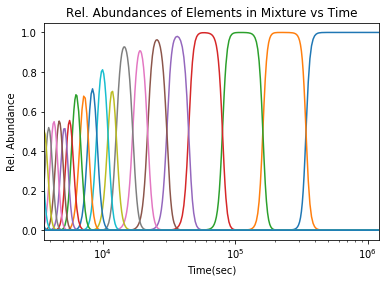

This is the graph for element  101 so there are  102  ionization states graphed


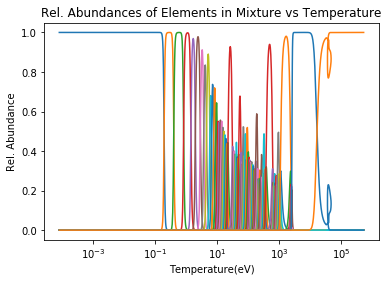

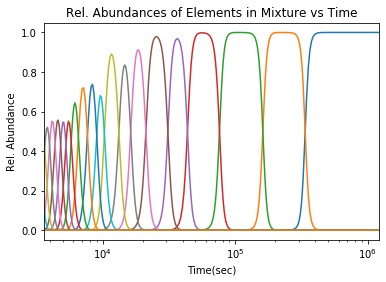

This is the graph for element  102 so there are  103  ionization states graphed


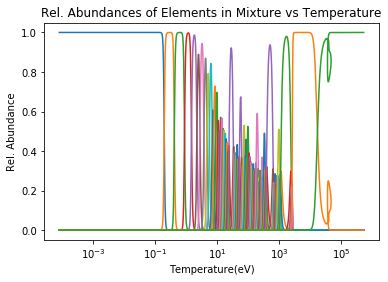

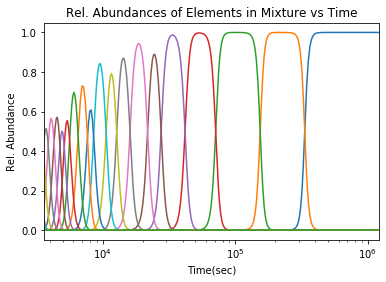

This is the graph for element  103 so there are  104  ionization states graphed


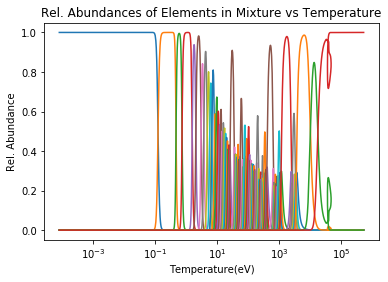

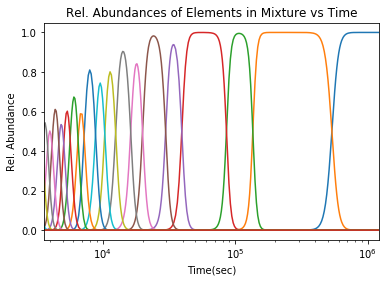

In [38]:
#Just plotting all the lanthanide and actinide abundances seperately
element_num = 58 #Z of first lanthanide
for Y in YI:
    Ytot = np.sum(Y,1)
    print('This is the graph for element ',element_num,'so there are ',element_num+1,' ionization states graphed')
    for i in range(len(Y[0])):
        plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot)
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    plt.show()
    for i in range(len(Y[0])):
        plt.semilogx(np.array(time),(Y[:,i])/Ytot)
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Time")
        plt.xlim([3600,1.21e+6])
    element_num+=1
    plt.show()
        

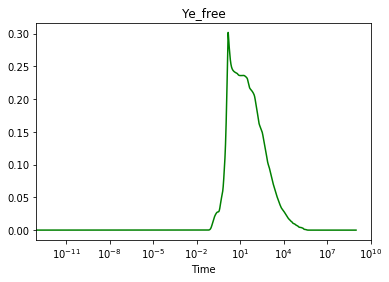

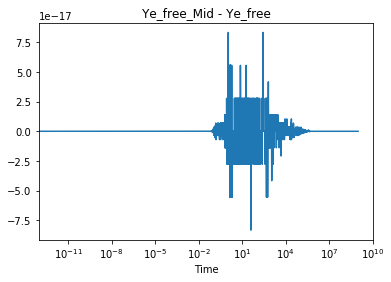

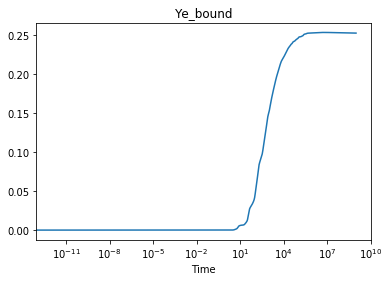

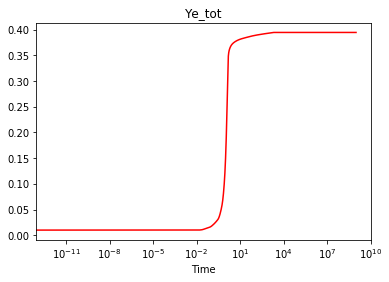

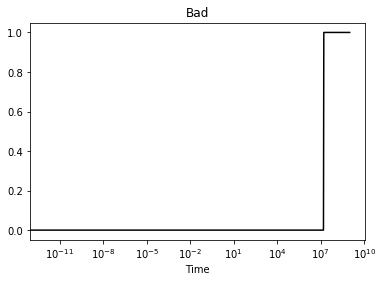

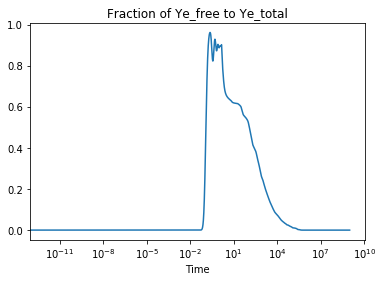

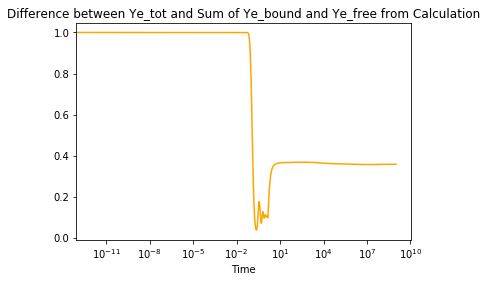

0
0     0.010000
1     0.010000
2     0.010000
3     0.010000
4     0.010000
5     0.010000
6     0.010000
7     0.010000
8     0.010000
9     0.010000
10    0.010000
11    0.010000
12    0.010000
13    0.010000
14    0.010000
15    0.010000
16    0.010000
17    0.010000
18    0.010000
19    0.010000
20    0.010000
21    0.010000
22    0.010000
23    0.010000
24    0.010000
25    0.010000
26    0.010000
27    0.010000
28    0.010000
29    0.010001
...        ...
2168  0.141354
2169  0.141357
2170  0.141361
2171  0.141364
2172  0.141367
2173  0.141373
2174  0.141378
2175  0.141383
2176  0.141388
2177  0.141393
2178  0.141398
2179  0.141402
2180  0.141407
2181  0.141412
2182  0.141417
2183  0.141422
2184  0.141427
2185  0.141432
2186  0.141437
2187  0.141442
2188  0.141447
2189  0.141452
2190  0.141456
2191  0.141461
2192  0.141465
2193  0.141469
2194  0.141473
2195  0.141477
2196  0.141481
2197  0.141485

[2198 rows x 1 columns]

In [39]:
#Now this cell will look at the Ye analysis for the lanthanide and actinide data

plt.semilogx(time,Ye_free[0],color = 'green') #Ye_free[0] is only because the shape of Ye_free is (1,2198) for some reason
plt.title('Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_f_Mid[0]) - np.array(Ye_free[0]))
plt.title('Ye_free_Mid - Ye_free')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,Ye_bound[0])
plt.xlabel('Time')
plt.title('Ye_bound')
plt.show()


plt.semilogx(time,Ye_tot,color = 'red')
plt.title('Ye_tot')
plt.xlabel('Time')
plt.show()

plt.title('Bad')
plt.semilogx(time,bad,color = 'black')
plt.xlabel('Time')
plt.show()

plt.semilogx(time,np.array(Ye_free[0])/np.array(Ye_tot))
plt.title('Fraction of Ye_free to Ye_total')
plt.xlabel('Time')
plt.show()

difference = np.array(Ye_tot) - (np.array(Ye_bound[0]) + np.array(Ye_free[0]))

plt.semilogx(time,difference/np.array(Ye_tot),color = 'orange')
plt.title('Difference between Ye_tot and Sum of Ye_bound and Ye_free from Calculation')
plt.xlabel('Time')
plt.show()
pd.DataFrame(difference)